In [1]:
import contextlib
from pathlib import Path

import matplotlib as mpl
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm

from amlta.probas import flows, processes

## Plotting setup for paper

- plots rendered using latex
- saved as pdf
- require no rescaling

In [2]:
DOC_WIDTH_PT = 443.8
DOC_HEIGHT_PT = 650

INCHES_PER_PT = 1 / 72.27
# Setup partly adapted from https://jwalton.info/Embed-Publication-Matplotlib-Latex/
#   and https://github.com/garrettj403/SciencePlots/blob/master/scienceplots/styles/science.mplstyle

# Golden ratio to set aesthetic figure height
# https://disq.us/p/2940ij3
GOLDEN_RATIO = (5**0.5 - 1) / 2


def set_size(
    width_pt=DOC_WIDTH_PT, fraction: float = 1, ratio=GOLDEN_RATIO, subplots=(1, 1)
):
    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Figure width in inches
    fig_width_in = fig_width_pt * INCHES_PER_PT
    # Figure height in inches
    fig_height_in = fig_width_in * ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)


# theme_color = "#202062"
theme_color = "#344068"
palette = sns.color_palette(f"light:{theme_color}")
palette_r = sns.color_palette(f"light:{theme_color}_r")
palette_cmap = sns.color_palette(f"light:{theme_color}", as_cmap=True)
palette_cmap_r = sns.color_palette(f"light:{theme_color}_r", as_cmap=True)


sns.set_theme(
    context="paper",
    style="ticks",
    palette=palette_r,
    rc={
        "figure.figsize": set_size(),
        "figure.dpi": 150,
        "savefig.dpi": 600,
        "savefig.bbox": "tight",
        "savefig.pad_inches": 0.01,
        "axes.grid": True,
        "grid.color": ".9",
        "grid.linestyle": "--",
        "axes.grid.which": "both",
        # "lines.markeredgecolor": "k",
        # "legend.edgecolor": "k",
        # "patch.force_edgecolor": True,
        # "axes.linewidth": 0.5,
        "grid.linewidth": 0.5,
        # "lines.linewidth": 1.,
        "text.usetex": True,
        "text.latex.preamble": (
            r"\usepackage[utf8]{inputenc}"
            r"\usepackage[T1]{fontenc}"
            r"\usepackage{amsmath}"
            r"\usepackage{amssymb}"
            r"\usepackage{lmodern}"
        ),
        "font.family": "serif",
        "mathtext.fontset": "dejavuserif",
        "font.size": 10,
        "axes.labelsize": "medium",
        "axes.titlesize": "medium",
        "figure.labelsize": "medium",
        "figure.titlesize": "medium",
        # Make the legend/label fonts a little smaller
        "legend.fontsize": "small",
        "legend.title_fontsize": "small",
        "xtick.labelsize": "small",
        "ytick.labelsize": "small",
    },
)


@contextlib.contextmanager
def plot_config(rc_update=None, /, **rc_updates):
    orig = mpl.rcParams
    updated = orig.copy()
    if rc_update:
        updated.update(rc_update)

    updated.update(**rc_updates)

    try:
        mpl.rcParams = updated
        yield
    finally:
        mpl.rcParams = orig


@contextlib.contextmanager
def plot_size(figsize=None, /, fontsize=None, **size_kwargs):
    conf = {}

    if not figsize and size_kwargs:
        conf["figure.figsize"] = set_size(**size_kwargs)
    elif figsize:
        conf["figure.figsize"] = figsize

    if fontsize:
        conf["font.size"] = fontsize

    with plot_config(conf):
        yield


base_path = Path().parent / "img"
base_path.mkdir(exist_ok=True)


def save_fig(figure, name, dpi=600, **kwargs):
    path = base_path / name
    if not path.suffix:
        path = path.with_suffix(".pdf")

    figure.savefig(path, dpi=dpi, **kwargs)
    print(f"Saved to {path}")

## Compile stats

In [3]:
uuids_all = processes.read_uuids(lci_results_only=False)
uuids_lci = processes.read_uuids(lci_results_only=True)

In [4]:
print(len(uuids_lci) / len(uuids_all))

0.507573469123549


In [5]:
lci_processes_gen = processes.ProcessData.from_uuids(uuids_lci)

In [6]:
stats = []
flows_stats = []

seen_flows = set()

In [7]:
_default_general_comment = "Kurzinfo: Datensatz aus GEMIS. Negative Werte durch Gutschriftenrechnung. \n \nGEMIS steht f\u00fcr \u201cGlobales Emissions-Modell Integrierter Systeme\u201c; es ist ein Softwaretool des \u00d6ko-Instituts. GEMIS wurde 1987 erstmals angewendet und wird seitdem weiterentwickelt. \n \nDie GEMIS-Datens\u00e4tze beruhen - je nach Anwendung - auf unterschiedlichen Methoden; auch der zeitliche und der \u00f6rtliche Bezug der Datens\u00e4tze sind verschieden.\n \nMethode bei Prozessen mit mehreren Outputs:\n \nZur Modellierung der Datens\u00e4tze zu Multi-Output Prozessen wird in GEMIS die Methode der Systemerweiterung verwendet. Hierbei werden Datens\u00e4tze, in denen jeweils alle Inputs, alle Outputs und alle Umweltaspekte eines Multi-Output Prozesses ausgewiesen sind, als \u201cBrutto\u201c bezeichnet. Durch Subtraktion von \u201aBonus\u2019-Prozessen, die jeweils einen der Outputs auf herk\u00f6mmliche Weise bereitstellen, entsteht ein Nettoprozess, in denen das substituierte Nebenprodukt als Gutschrift erscheint. Die Gutschrift ist dabei kein realer Output des Prozesses, sondern ein rechnerischer \u201aMerker\u2019. \n \nBeispiel: \n \nMulti-Output Prozess Biogas-BZ-MC-HKW-D-2020/brutto: Output ist 1 TJ Elektrizit\u00e4t und 0,6 TJ W\u00e4rme, der \u201cNetto\u201c-Datensatz soll sich aber nur auf die Elektrizit\u00e4t beziehen. Durch Subtraktion des Bonusprozesses W\u00e4rme-Bonus-Gas-Hzg-D-2020 mit dem Output W\u00e4rme(0,6 TJ) entsteht der \u201cNetto\u201c-Datensatz Biogas-BZ-MC-HKW-D-2020/Gas, f\u00fcr den als Output 1 TJ Elektrizit\u00e4t und 0,6 TJ \u201aGutschrift W\u00e4rme-Bonus-f\u00fcr-KWK (Bio)-2020 bei W\u00e4rme-Bonus-Gas-Hzg-D-2020\u2019 angegeben werden; die Gutschrift stellt keinen Stoff- oder Energiefluss des Prozesses dar, sie ist allein rechnerisch begr\u00fcndet.\n \n\n \nTransport:\n \nAngaben zu den angesetzten Transportdistanzen werden nicht gegeben.\n \nAbschneidekriterien:\n \nWasser wird in der Regel nur auf der Inputseite angegeben (etwa als K\u00fchlwasser), auch wenn es den Prozess wieder verl\u00e4sst als Abwasser.\n Weitere Angaben zu angewendeten Abschneidekriterien werden nicht gegeben.\n \nBesondere Nomenklatur:\n \nZahlreiche Abk\u00fcrzungen f\u00fcr Brennstoffe aus Biomasse und entsprechende Technologien.\n \nBesonderheiten auf Datensatzebene:\n \nDie Datens\u00e4tze sind mit Vorketten-Datens\u00e4tzen verkn\u00fcpft, in denen die jeweils ben\u00f6tigten Vorprodukte, Energien und Transportleistungen erzeugt werden. Die Daten zu den Umweltaspekten werden erstens \u201cdirekt\u201c (d.h., nur aus dem jeweiligen Prozess, falls dieser direkt zu Umweltaspekten beitr\u00e4gt) als auch \u201cmit Vorkette\u201c (d.h., einschlie\u00dflich aller vorausgehenden Prozesse) ausgewiesen. \n Negative Werte f\u00fcr Stofffl\u00fcsse kommen in GEMIS regelm\u00e4\u00dfig vor; sie entstehen durch die Anwendung von Systemerweiterung um Multi-Output Prozesse in Single Output Prozesse umzurechnen. \n Teilweise werden Aufwendungen f\u00fcr Produktionsmittel (Anlagen, Fahrzeuge etc.) aufgef\u00fchrt (als Stofffl\u00fcsse im Input); diese sind jedoch nicht auf die funktionelle Einheit bezogen, sondern werden als absolute Werte angegeben; sie werden nur als Input und nicht als Output (Entsorgung der Betriebsmittel) angegeben. \n Die durch die Herstellung dieser Produktionsmittel verursachten Umweltaspekte sind dagegen \u00fcber Leistung, j\u00e4hrliche Auslastung und Lebensdauer auf die funktionelle Einheit bezogen \n \nWeiterf\u00fchrende Hinweise und Literatur:\n \n#1: Fritsche, U.R., Schmidt, K.: Globales Emissions-Modell Integrierter Systeme (GEMIS), Version 4.2, Handbuch, Darmstadt, August 2004.\n #2: Fritsche, U.R., Schmidt, K.: Globales Emissions-Modell Integrierter Systeme (GEMIS), Version 4.1, Handbuch, Darmstadt, Darmstadt, Januar 2003.\n #3: Fritsche, U., et al.: Stoffstromanalyse zur nachhaltigen energetischen Nutzung von Biomasse, Verbundprojekt gef\u00f6rdert vom BMU im Rahmen des ZIP, Projekttr\u00e4ger: FZ J\u00fclich, Mai 2004, Anhangband zum Endbericht.\n #4: Fritsche, U., et al.: Umweltanalyse von Energie-, Transport- und Stoffsystemen: Gesamt-Emissions-Modell integrierter Systeme (GEMIS) Version 2.1 - erweiterter und aktualisierter Endbericht, U. Fritsche u.a., i.A. des Hessischen Ministeriums f\u00fcr Umwelt, Energie und Bundesangelegenheiten (HMUEB), ver\u00f6ffentlicht durch HMUEB, Wiesbaden 1995"

for process in tqdm(lci_processes_gen, total=len(uuids_lci)):
    processes.type_ctx.set("processes")

    uuid = process.processInformation.dataSetInformation.UUID
    name = process.processInformation.dataSetInformation.name.baseName.get()
    if synonyms := process.processInformation.dataSetInformation.synonyms:
        synonyms = synonyms.get()

    class_levels = {}

    classes = process.processInformation.dataSetInformation.classificationInformation.classification
    if classes:
        for item in classes:
            for class_item in item.class_:
                class_levels[f"class_level_{class_item.level}"] = class_item.value

    processes.type_ctx.set("flows")
    process_flows = flows.extract_process_flows(process)

    input_flows = len(process_flows.loc[process_flows["exchange_direction"] == "INPUT"])
    output_flows = len(
        process_flows.loc[process_flows["exchange_direction"] == "OUTPUT"]
    )

    main_output_exchange = process.get_main_output()
    if main_output_exchange:
        main_flow_uuid = main_output_exchange.referenceToFlowDataSet.refObjectId
        main_flow_name = process_flows.loc[
            process_flows["flow_uuid"] == main_flow_uuid, "flow_description"
        ].values[0]
    else:
        main_flow_uuid = None
        main_flow_name = None

    for _, row in process_flows.iterrows():
        direction = row["exchange_direction"]
        flow_type = row["exchange_type_of_flow"]
        class_ = row["exchange_classification_hierarchy"]
        flow_uuid = row["flow_uuid"]
        is_main_output_flow = (
            flow_uuid == main_flow_uuid
            and direction == "OUTPUT"
            and flow_type == "Product flow"
        )

        flow_uq = (flow_uuid, direction, flow_type, class_, is_main_output_flow)

        unit_property = row["flow_property_name"]
        unit = row["flow_property_unit"]
        name = row["flow_description"]

        if flow_uq not in seen_flows:
            seen_flows.add(flow_uq)
            flows_stats.append(
                {
                    "uuid": flow_uuid,
                    "name": name,
                    "direction": direction,
                    "unit_property": unit_property,
                    "unit": unit,
                    "flow_type": flow_type,
                    "class": class_,
                    "is_main_output_flow": is_main_output_flow,
                }
            )

    processes.type_ctx.set("processes")
    geography = process.processInformation.geography.locationOfOperationSupplyOrProduction.location
    year = process.processInformation.time.referenceYear
    year_until = process.processInformation.time.dataSetValidUntil

    has_technology = (
        process.processInformation.technology.technologyDescriptionAndIncludedProcesses
        is not None
        and bool(
            process.processInformation.technology.technologyDescriptionAndIncludedProcesses.get()
        )
    )

    has_comment = (
        process.processInformation.dataSetInformation.generalComment is not None
        and (
            comment
            := process.processInformation.dataSetInformation.generalComment.get()
        )
        and _default_general_comment not in comment
    )

    stats.append(
        {
            "uuid": uuid,
            "name": name,
            "synonyms": synonyms,
            **class_levels,
            "input_flows": input_flows,
            "output_flows": output_flows,
            "main_flow_uuid": main_flow_uuid,
            "main_flow_name": main_flow_name,
            "geography": geography,
            "has_technology": has_technology,
            "has_comment": has_comment,
            "year": year,
            "year_until": year_until,
        }
    )

  0%|          | 0/11762 [00:00<?, ?it/s]

### Languages

In [31]:
processes.language_stats

{'processes': Counter({'de': 34835, 'en': 552}),
 'flows': Counter({'en': 2473904, 'de': 12768})}

Saved to img\probas-processes-langs.pdf


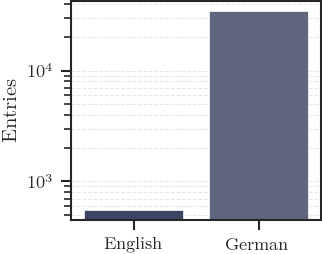

In [32]:
w, h = set_size(subplots=(1, 2))

with plot_size((w * 0.35, h)):
    ax = sns.barplot(
        pd.DataFrame(dict(processes.language_stats["processes"]), index=["count"])[
            ["en", "de"]
        ].rename(
            columns={
                "en": "English",
                "de": "German",
            }
        )
    )
    ax.set_yscale("log")
    ax.set_ylabel("Entries")

    save_fig(ax.figure, "probas-processes-langs")

Saved to img\probas-flows-langs.pdf


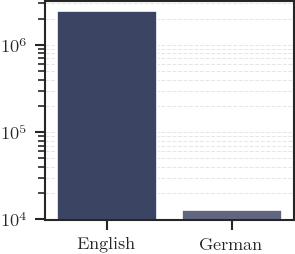

In [33]:
with plot_size((w * 0.35, h)):
    ax = sns.barplot(
        pd.DataFrame(dict(processes.language_stats["flows"]), index=["count"])[
            ["en", "de"]
        ].rename(
            columns={
                "en": "English",
                "de": "German",
            }
        ),
    )
    ax.set_yscale("log")

    save_fig(ax.figure, "probas-flows-langs")

In [34]:
process_df = pd.DataFrame(stats)
flows_df = pd.DataFrame(flows_stats)

In [35]:
# # ignore flows that are the process outputs itself
# actual_flows_mask = ~(
#     (flows_df["flow_type"] == "Product flow") &
#     (flows_df["direction"] == "OUTPUT") &
#     (flows_df["class"] == "Systems / Other systems") &
#     (flows_df["uuid"].isin(process_df["main_flow_uuid"]))
# )

actual_flows_mask = ~flows_df["is_main_output_flow"]

In [36]:
flows_df[actual_flows_mask]

,uuid,name,direction,unit_property,unit,flow_type,class,is_main_output_flow
0,814cedc6-b3ec-4474-86fa-051740192dec,secondary raw materials,INPUT,Net calorific value,MJ,Waste flow,End-of-life treatment / Energy recycling,False
1,0e0b2476-9043-11d3-b2c8-0080c8941b49,secondary raw materials,INPUT,Mass,kg,Waste flow,End-of-life treatment / Material recycling,False
2,0e0b2403-9043-11d3-b2c8-0080c8941b49,NF-scrap,INPUT,Mass,kg,Waste flow,End-of-life treatment / Other end-of-life serv...,False
3,a22c8047-fd56-49a4-8dd2-0c0e54c60cc6,waste,INPUT,Net calorific value,MJ,Waste flow,End-of-life treatment / Other end-of-life serv...,False
4,cc0e481c-80da-11d4-9e81-0080c8426c9a,Fe-scrap,INPUT,Mass,kg,Waste flow,End-of-life treatment / Material recycling,False
...,...,...,...,...,...,...,...,...
3007,0841132b-d310-5ef8-a291-ce82e0ac6e1c,"polyethylene terephthalate, granulate, amorpho...",None,Mass,kg,Product flow,"Other transportable goods, except metal produc...",False
3008,aeabc7b8-67ba-5d1d-95a2-9cef161e6daf,formaldehyde,None,Mass,kg,Product flow,"Other transportable goods, except metal produc...",False
3010,1de08e74-aad7-5632-bd70-edad0325dc6f,"ilmenite, 54% titanium dioxide",None,Mass,kg,Product flow,"Metal products, machinery and equipment / Basi...",False
3011,1b56153b-ed8b-5047-8a4e-418ba9cb8690,"iron ore, crude ore, 46% Fe",None,Mass,kg,Product flow,"Ores and minerals; electricity, gas and water ...",False


### Flows

In [37]:
len(flows_df[actual_flows_mask])

2090

In [38]:
uuid_counts = flows_df["uuid"].value_counts()
duplicate_uuids = uuid_counts[uuid_counts > 1].index
flows_df.loc[flows_df["uuid"].isin(duplicate_uuids)].sort_values("uuid")

,uuid,name,direction,unit_property,unit,flow_type,class,is_main_output_flow
20,08a91e70-3ddc-11dd-9136-0050c2490048,waste heat,INPUT,Net calorific value,MJ,Elementary flow,Emissions / Emissions to air / Emissions to ai...,False
368,08a91e70-3ddc-11dd-9136-0050c2490048,waste heat,OUTPUT,Net calorific value,MJ,Elementary flow,Emissions / Emissions to air / Emissions to ai...,False
1285,08a91e70-3ddc-11dd-9409-0050c2490048,fluroxypyr,OUTPUT,Mass,kg,Elementary flow,Emissions / Emissions to soil / Emissions to a...,False
2174,08a91e70-3ddc-11dd-9409-0050c2490048,fluroxypyr,INPUT,Mass,kg,Elementary flow,Emissions / Emissions to soil / Emissions to a...,False
2152,0fdfa11c-0397-4f46-b1cf-d9266d5a5a13,"Volume occupied, final repository for radioact...",INPUT,Volume,m3,Elementary flow,Land use / Land occupation,False
1041,0fdfa11c-0397-4f46-b1cf-d9266d5a5a13,"Volume occupied, final repository for radioact...",OUTPUT,Volume,m3,Elementary flow,Land use / Land occupation,False
2153,1058891f-9dbe-419c-ae48-9d03289eeb39,"from traffic area, road network",INPUT,Area,m2,Elementary flow,Land use / Land transformation,False
1022,1058891f-9dbe-419c-ae48-9d03289eeb39,"from traffic area, road network",OUTPUT,Area,m2,Elementary flow,Land use / Land transformation,False
900,1fc2328b-d860-4aa7-ac27-34aa1cce4f9d,"Volume occupied, final repository for low-acti...",OUTPUT,Volume,m3,Elementary flow,Land use / Land occupation,False
2151,1fc2328b-d860-4aa7-ac27-34aa1cce4f9d,"Volume occupied, final repository for low-acti...",INPUT,Volume,m3,Elementary flow,Land use / Land occupation,False


In [39]:
flows_df[actual_flows_mask]["flow_type"].value_counts()

flow_type
Elementary flow    1902
Product flow        175
Waste flow           13
Name: count, dtype: int64

In [ ]:
flows_df[actual_flows_mask]["class"].value_counts()

class
Emissions / Emissions to soil / Emissions to agricultural soil                                                                                                                                                274
Emissions / Emissions to water / Emissions to fresh water                                                                                                                                                     258
Emissions / Emissions to air / Emissions to non-urban air or from high stacks                                                                                                                                 249
Emissions / Emissions to air / Emissions to urban air close to ground                                                                                                                                         215
Emissions / Emissions to air / Emissions to air, unspecified                                                                                              

class
Emissions / Emissions to soil / Emissions to agricultural soil                                                                                                                                                274
Emissions / Emissions to water / Emissions to fresh water                                                                                                                                                     258
Emissions / Emissions to air / Emissions to non-urban air or from high stacks                                                                                                                                 249
Emissions / Emissions to air / Emissions to urban air close to ground                                                                                                                                         215
Emissions / Emissions to air / Emissions to air, unspecified                                                                                              

In [ ]:
def get_class_upto_level(class_label_row, level=2):
    class_label = class_label_row["class"]
    if not isinstance(class_label, str):
        return class_label, class_label

    parts = class_label.split(" / ")
    return " / ".join(parts[:level]), (
        parts[level - 1] if len(parts) >= level else None
    )


flows_df[["class_upto_level_2", "class_level_2"]] = flows_df[["class"]].apply(
    get_class_upto_level, axis=1, result_type="expand"
)

In [ ]:
flows_df

,uuid,name,direction,unit_property,unit,flow_type,class,is_main_output_flow,class_upto_level_2,class_level_2
0,814cedc6-b3ec-4474-86fa-051740192dec,secondary raw materials,INPUT,Net calorific value,MJ,Waste flow,End-of-life treatment / Energy recycling,False,End-of-life treatment / Energy recycling,Energy recycling
1,0e0b2476-9043-11d3-b2c8-0080c8941b49,secondary raw materials,INPUT,Mass,kg,Waste flow,End-of-life treatment / Material recycling,False,End-of-life treatment / Material recycling,Material recycling
2,0e0b2403-9043-11d3-b2c8-0080c8941b49,NF-scrap,INPUT,Mass,kg,Waste flow,End-of-life treatment / Other end-of-life serv...,False,End-of-life treatment / Other end-of-life serv...,Other end-of-life services
3,a22c8047-fd56-49a4-8dd2-0c0e54c60cc6,waste,INPUT,Net calorific value,MJ,Waste flow,End-of-life treatment / Other end-of-life serv...,False,End-of-life treatment / Other end-of-life serv...,Other end-of-life services
4,cc0e481c-80da-11d4-9e81-0080c8426c9a,Fe-scrap,INPUT,Mass,kg,Waste flow,End-of-life treatment / Material recycling,False,End-of-life treatment / Material recycling,Material recycling
...,...,...,...,...,...,...,...,...,...,...
3019,0d5e4a18-22fb-4509-aee5-c691cb27ed44,grass (cuttings)-DE-2010,OUTPUT,Net calorific value,MJ,Product flow,Systems / Other systems,True,Systems / Other systems,Other systems
3020,a9f47b8f-9adb-57bf-b8b2-14cb94aa3cef,"copper concentrate, sulfide ore",None,Mass,kg,Product flow,"Ores and minerals; electricity, gas and water ...",False,"Ores and minerals; electricity, gas and water ...",Metal ores
3021,0e0b2459-9043-11d3-b2c8-0080c8941b49,R600a (iso-Butan),OUTPUT,Mass,kg,Product flow,Systems / Other systems,True,Systems / Other systems,Other systems
3022,890e25a9-4e5a-4197-b369-8d643019b4a1,electricity-DE-RE/CO-2020,OUTPUT,Net calorific value,MJ,Product flow,Systems / Other systems,True,Systems / Other systems,Other systems


In [ ]:
top_flow_classes = (
    flows_df.loc[actual_flows_mask]["class_level_2"].value_counts().to_frame()
)
top_flow_classes

,count
class_level_2,
Emissions to air,751
Emissions to water,507
Emissions to soil,367
Resources from ground,98
Land transformation,78
Basic chemicals,69
Land occupation,44
Basic metals,30
Resources from water,14


Saved to img\probas-top-flow-classes.pdf


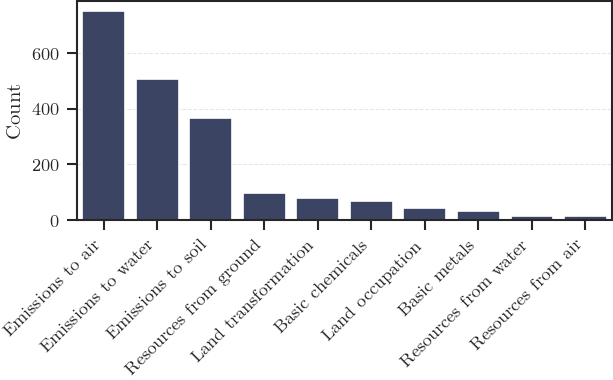

In [ ]:
w, h = set_size(subplots=(1, 2))

with plot_size((w * 0.75, h)):
    ax = sns.barplot(
        data=top_flow_classes.iloc[:10],
        x="class_level_2",
        y="count",
    )

    ax.set_xlabel("")
    ax.set_ylabel("Count")

    ax.set_xticks(range(len(ax.get_xticklabels())))
    ax.tick_params(axis="x", labelrotation=45)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

    save_fig(ax.figure, "probas-top-flow-classes")

Saved to img\probas-flow-types-count.pdf


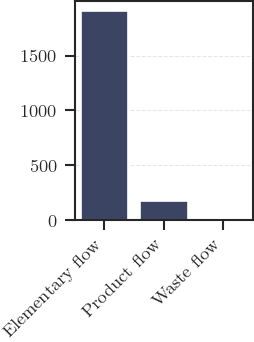

In [ ]:
with plot_size((w * 0.25, h)):
    ax = sns.barplot(
        flows_df.loc[actual_flows_mask]["flow_type"]
        .value_counts()
        .reset_index(
            name="count",
        ),
        x="flow_type",
        y="count",
    )

    ax.set_xlabel("")
    ax.set_ylabel("")

    ax.set_xticks(range(len(ax.get_xticklabels())))
    ax.tick_params(axis="x", labelrotation=45)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

    save_fig(ax.figure, "probas-flow-types-count")

In [ ]:
flows_df[actual_flows_mask]["direction"].value_counts().reset_index(
    name="count",
)

,direction,count
0,OUTPUT,1752
1,INPUT,163


<Axes: xlabel='direction', ylabel='count'>

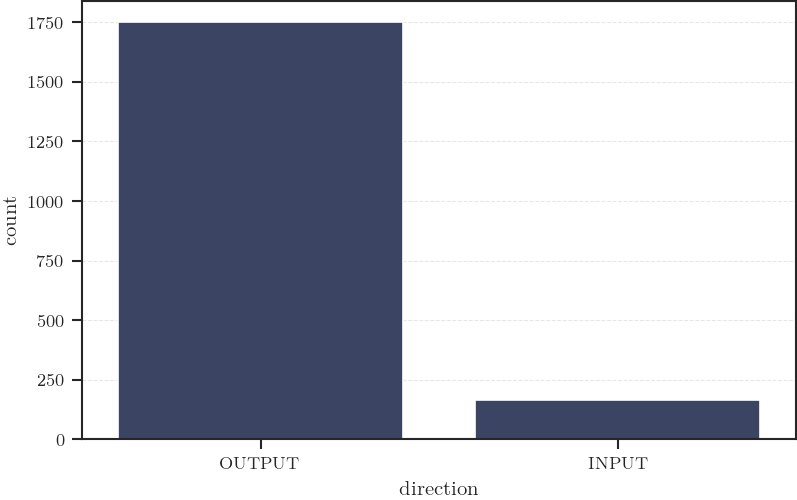

In [ ]:
sns.barplot(
    flows_df[actual_flows_mask]["direction"]
    .value_counts()
    .reset_index(
        name="count",
    ),
    x="direction",
    y="count",
)

### Processes

In [ ]:
class_level_columns = [
    col for col in process_df.columns if col.startswith("class_level_")
]
other_columns = [
    col for col in process_df.columns if not col.startswith("class_level_")
]

process_df = process_df[
    other_columns[:3] + sorted(class_level_columns) + other_columns[3:]
]

In [ ]:
process_df

,uuid,name,synonyms,class_level_0,class_level_1,class_level_2,class_level_3,class_level_4,class_level_5,input_flows,output_flows,main_flow_uuid,main_flow_name,geography,has_technology,has_comment,year,year_until
0,9db4c992-9281-466c-8adc-eb1daddda800,Gas-HKW-GuD-gross-DK-2015-th/en,None,Energieversorgung,Fernwärmeversorgung,NaN,NaN,NaN,NaN,21,60,0e0b24c6-9043-11d3-b2c8-0080c8941b49,warm water,DK,True,False,2015,NaN
1,50e9e77d-f431-4e05-82d8-ccf3de8ff1c9,Gas-Heizung-SK-2020,None,Verbrauch-Haushalte,NaN,NaN,NaN,NaN,NaN,21,60,0e0b2461-9043-11d3-b2c8-0080c8941b49,space heat,SK,True,False,2020,NaN
2,d29b4a91-90ec-44e0-a8b0-148d57fb0889,Xtra-onshore\Gas-RU-2015,None,"Gewinnung von Erdöl und Erdgas, Erbringung dam...",Gewinnung von Erdöl und Erdgas,NaN,NaN,NaN,NaN,21,60,0e0b2378-9043-11d3-b2c8-0080c8941b49,natural gas-RU,RU,True,False,2015,NaN
3,b5703309-67df-4ff2-84ee-f55ff80f7604,Verdichter-GT-DK-2020,None,Energieversorgung,Gasversorgung,Gasverteilung und -handel durch Rohrleitungen,NaN,NaN,NaN,21,60,b11c62e8-a5b4-11d3-b42d-fed95173dc12,mechanical-energy,DK,True,False,2020,NaN
4,0fdc211d-4815-4f9d-81b9-dc3cb6f08036,Xtra-mix\Uran-ZA-2000,None,Bergbau auf Uran- und Thoriumerze,NaN,NaN,NaN,NaN,NaN,20,60,0e0b24bd-9043-11d3-b2c8-0080c8941b49,uranium,ZA,True,False,2000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11757,64682f46-8eca-4038-87ab-19c4e9dfcd5a,Pipeline\Biomethan-Mais-iLUC50% (Acker)-DE-2030,None,Energieversorgung,Gasversorgung,Gasverteilung und -handel durch Rohrleitungen,NaN,NaN,NaN,21,60,22f1eb67-0337-40a2-a42d-ca2cf3318da5,biogas-processed-for-gas-pipeline,DE,True,False,2030,NaN
11758,a6a4718a-9ffc-440c-a8cf-8bf294d54b18,Gas-mix-BR-2020,None,Energieversorgung,Gasversorgung,NaN,NaN,NaN,NaN,21,49,cc0e4887-80da-11d4-9e81-0080c8426c9a,gas-from-lignite-CZ,BR,True,False,2020,NaN
11759,2cc29c94-8b87-44a7-a92e-1c7b3455367f,Biogas-Mais-dLUC (Grünland)-BHKW-500 kW DE-201...,None,Energieversorgung,Elektrizitätsversorgung,Elektrizitätserzeugung,NaN,NaN,NaN,21,60,0e0b235d-9043-11d3-b2c8-0080c8941b49,electricity,DE,True,False,2010,NaN
11760,95d344c7-7974-4060-9ccc-0b26b19f18a0,Pipeline\Gas-UA-2005,None,Energieversorgung,Gasversorgung,Gasverteilung und -handel durch Rohrleitungen,NaN,NaN,NaN,21,60,b993e9b1-d7c1-4638-8e0d-94dceeabf028,natural gas-UA,UA,True,False,2005,NaN


In [ ]:
def shorten_label(label: str, max_len=15):
    return label[:max_len] + "..." if len(label) > max_len - 2 else label


def get_label(row):
    l1 = row["class_level_1"]
    if pd.isna(l1):
        l1 = row["class_level_0"]

    if pd.isna(l1):
        return l1
    else:
        return shorten_label(l1)


level_1_labels = process_df.apply(get_label, axis=1)
# ["class_level_1"].map(
#     lambda s: (s[:25] + "...") if not pd.isna(s) and len(s) > 26 else s
# )

Saved to img\probas-classes-count.pdf


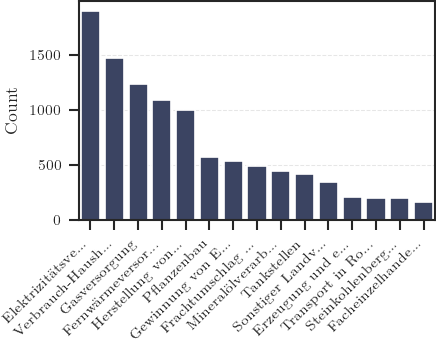

In [ ]:
with plot_size(fontsize=8, fraction=0.5):
    ax = sns.barplot(
        data=level_1_labels.value_counts().iloc[:15],  # type: ignore
    )

    ax.set_xlabel("")
    ax.set_ylabel("Count")

    ax.set_xticks(range(len(ax.get_xticklabels())))
    ax.tick_params(axis="x", labelrotation=45)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

    save_fig(ax.figure, "probas-classes-count")

Saved to img\probas-output-flows-count.pdf


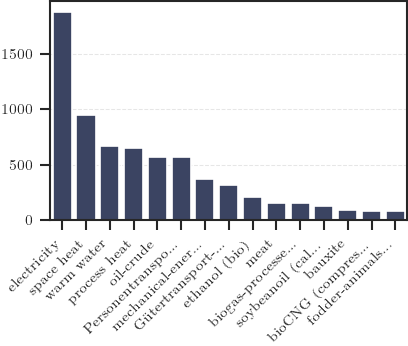

In [ ]:
with plot_size(fontsize=8, fraction=0.5):
    ax = sns.barplot(
        process_df["main_flow_name"]
        .apply(shorten_label, max_len=15)
        .value_counts()
        .iloc[:15]  # type: ignore
    )

    ax.set_xlabel("")
    ax.set_ylabel("")

    ax.set_xticks(range(len(ax.get_xticklabels())))
    ax.tick_params(axis="x", labelrotation=45)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

    save_fig(ax.figure, "probas-output-flows-count")

In [ ]:
display(process_df["input_flows"].describe())
display(process_df["output_flows"].describe())

count    11762.000000
mean        21.566060
std         12.100946
min          1.000000
25%         21.000000
50%         21.000000
75%         21.000000
max        114.000000
Name: input_flows, dtype: float64

count    11762.000000
mean        83.633991
std        203.953048
min         45.000000
25%         60.000000
50%         60.000000
75%         60.000000
max       1702.000000
Name: output_flows, dtype: float64

In [ ]:
(process_df["geography"].isna()).sum()

np.int64(328)

Saved to img\probas-input-output-flows-scatter.pdf


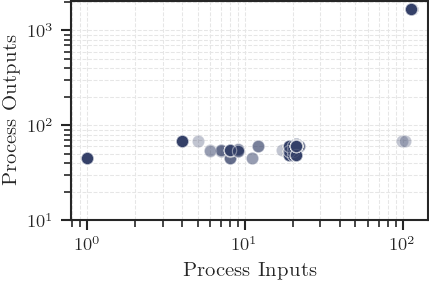

In [ ]:
with plot_size(fraction=0.5):
    ax = sns.scatterplot(
        data=process_df,
        x="input_flows",
        y="output_flows",
        alpha=0.3,
        s=35,
    )

    ax.set_xlabel("Process Inputs")
    ax.set_ylabel("Process Outputs")

    ax.set_xscale("log")
    ax.set_yscale("log")

    ax.set_ylim(ymin=10)

    save_fig(ax.figure, "probas-input-output-flows-scatter")

In [ ]:
process_df["geography"].value_counts().to_frame().iloc[:15]

,count
geography,
DE,4716
RER,1100
BR,327
RU,253
US,220
AU,208
ID,203
PL,197
CA,196


In [ ]:
print(process_df["geography"].value_counts().to_frame().iloc[:15].to_latex())

\begin{tabular}{lr}
\toprule
 & count \\
geography &  \\
\midrule
DE & 4716 \\
RER & 1100 \\
BR & 327 \\
RU & 253 \\
US & 220 \\
AU & 208 \\
ID & 203 \\
PL & 197 \\
CA & 196 \\
GB & 141 \\
NL & 135 \\
ES & 134 \\
FR & 133 \\
UA & 132 \\
AT & 132 \\
\bottomrule
\end{tabular}

